In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from Solver import *
from functools import partial
import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault



# Load Data

In [2]:
Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd
beta = 3.0
rek = 0.3                     # bottom drag rek
U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
beta1, beta2 = beta + F1*dU, beta - F2*dU
hyper_nu, hyper_order = 0.0, 2
Q = 1.0

yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)

    
    
folder_name = "/central/groups/esm/dzhuang/pyqg_run/2layer/nx256beta3rek0p3/"
file_name = 'nx256beta3rek0p3'
start, end, step = 500000, 1000000, 20000
flow_means, flow_zonal_means = preprocess_data(folder_name, file_name, beta, dU, L, start, end, step)
mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean, psi_var_2_mean = flow_means[:8]
q_zonal_mean, dq_zonal_mean = flow_zonal_means[:2]



# Start 1D plug-in simulation

In [2]:
omega = np.ones(256)
dx = 0.1
order = 2
t = time.time()
for i in range(1000):
    gradient_fft(omega, dx, order)
print("t = ", time.time() - t)


t = time.time()
for i in range(10000):
    fft(omega)
print("t = ", time.time() - t)

q = np.ones((2,256))
F1, F2, dy = 1.0, 1.0, 0.1
t = time.time()
for i in range(1000):
    psi_fft_sol(q, F1, F2, dy)
print("t = ", time.time() - t)


NameError: name 'time' is not defined

In [4]:
import time

def explicit_solve(model, f, q0, params, dt = 1.0, Nt = 1000, save_every = 1):
    L, dU, F1, F2, beta, rek = params.L, params.dU, params.F1, params.F2, params.beta, params.rek
    hyper_nu, hyper_order = params.hyper_nu, params.hyper_order
    
    _, Ny = q0.shape
    yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny
    
    t = 0.0
    
    q = np.copy(q0)
    
    # prepare data storage
    q_data = np.zeros((Nt//save_every+1, 2, Ny))
    t_data = np.zeros(Nt//save_every+1)
    q_data[0, :, :], t_data[0] = q, t
    
    tend = np.zeros((2, Ny))
    res = np.zeros((2, Ny))
    
    t_1, t_2 = time.time(), time.time()
    for i in range(1, Nt+1): 
        psi = psi_fft_sol(q, F1, F2, dy)
        dd_psi2 = gradient_fft(psi[1, :], dy, 2)
        model(q, psi, yy, res)
        tend[:,:] = f + res          # Turn off hyperdiffusion    + hyperdiffusion(q, hyper_nu, hyper_order, dy)
        tend[1,:] -= rek*dd_psi2

        q += dt * tend
        
        if i%save_every == 0:
            q_data[i//save_every, :, :] = q
            t_data[i//save_every] = i*dt   
            
            t_1 = t_2
            t_2 = time.time()
            print(i, "max q", np.max(q), " time elapse: ", t_2 - t_1)

    return  yy, t_data, q_data


In [9]:
# reset the resolution
def coarsen(v):
    if v.ndim == 2:
        n = v.shape[1]
        assert(n %2 == 0)
        return (v[:, 0::2] + v[:, 1::2])/2.0
    elif v.ndim == 1:
        n = len(v)
        assert(n %2 == 0)
        return (v[0::2] + v[1::2])/2.0
    else:
        print("coarsen v with dimension: ", v.ndim, " has not implemented")
    return v


mu_mean_clip = np.copy(mu_mean)
# TODO: clean data
mu_mean_clip[mu_mean_clip <= 0.0 ] = 0.0

for layer in range(2):
    mu_mean_clip[layer, :] = scipy.ndimage.gaussian_filter1d(mu_mean_clip[layer, :], 5)

            
dt = 4e-3 
save_every = 1000
Nt = 400000 
COARSEN_MESH = False
if COARSEN_MESH: 
    Ny = Ny//2
    force = coarsen(force)
    mu_mean_clip = coarsen(mu_mean_clip)
    yy = coarsen(yy)
    dt *= 2.0
    

# q0 = np.copy(q_mean)
q0 = np.zeros((2, Ny))
# q0[0, :] = 1e-1 * np.sin(2*np.pi*yy/L)
# q0[1, :] = 1e-1 * np.cos(2*np.pi*yy/L)

q0[0, :] = -beta*L/2 * np.sin(2*np.pi*yy/L)
q0[1, :] =  beta*L/2 * np.cos(2*np.pi*yy/L)
    
params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta, rek=rek)


def mu_model(x):
    return mu_mean_clip.flatten()


model = partial(nummodel, mu_model, beta1, beta2)
yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = save_every)


1000 max q 476.43484836216476  time elapse:  0.38279128074645996
2000 max q 480.4896653956058  time elapse:  0.34910106658935547
3000 max q 483.6503640394661  time elapse:  0.3453073501586914
4000 max q 486.2204836376408  time elapse:  0.3441426753997803
5000 max q 488.14472133950846  time elapse:  0.36170291900634766
6000 max q 489.52935466714445  time elapse:  0.3560633659362793
7000 max q 490.5101974038956  time elapse:  0.36019015312194824
8000 max q 491.1932508903846  time elapse:  0.3567225933074951
9000 max q 491.5421236015352  time elapse:  0.3510918617248535


KeyboardInterrupt: 

Text(0.5, 1.0, 'average on last 1000 frames')

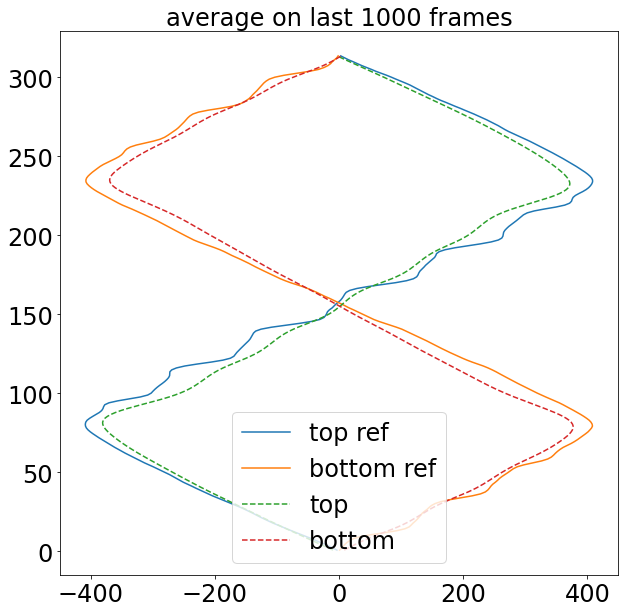

In [7]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[0, :], yy, label="top ref")
ax.plot(q_mean_ref[1, :], yy, label="bottom ref")

ax.plot(np.mean(q_data[Nt//(2*save_every):, 0, :], axis=0), yy, "--", label="top")
ax.plot(np.mean(q_data[Nt//(2*save_every):, 1, :], axis=0), yy, "--", label="bottom")

ax.legend()
plt.title("average on last 1000 frames")